## AIS Data 
Data below came from https://marinecadastre.gov/ais/  

Zone 11, January 2016

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,6
import warnings
warnings.filterwarnings("ignore")

from geopy.distance import great_circle, vincenty


from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

ModuleNotFoundError: No module named 'geopy'

In [3]:
df = pd.read_csv('AIS_2016_01_Zone11.csv')
print(df.shape)
df.head()

(7702375, 16)


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,399989190,2016-01-01T00:00:27,33.20498,-117.39145,0.0,50.4,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338092107,2016-01-01T00:00:43,33.72583,-118.07640,0.0,-49.6,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,367363686,2016-01-01T00:01:18,33.77162,-118.21172,0.0,123.8,64.0,NaN,NaN,NaN,NaN,under way using engine,NaN,NaN,NaN,NaN
3,215030000,2016-01-01T00:01:18,33.07720,-118.02773,13.2,-53.3,357.0,NaN,NaN,NaN,NaN,under way using engine,NaN,NaN,NaN,NaN
4,338433000,2016-01-01T00:01:59,34.14874,-119.20302,0.0,-123.7,211.0,ADMIRAL TIDE,IMO9184524,WDG7881,77.0,moored,62.0,14.0,3.7,77.0


## What is all this data?
### Initial dataframe for one month in one area (Zone 11) is 7,702,375 rows. What is this data and is this useful for avoidance collision? 

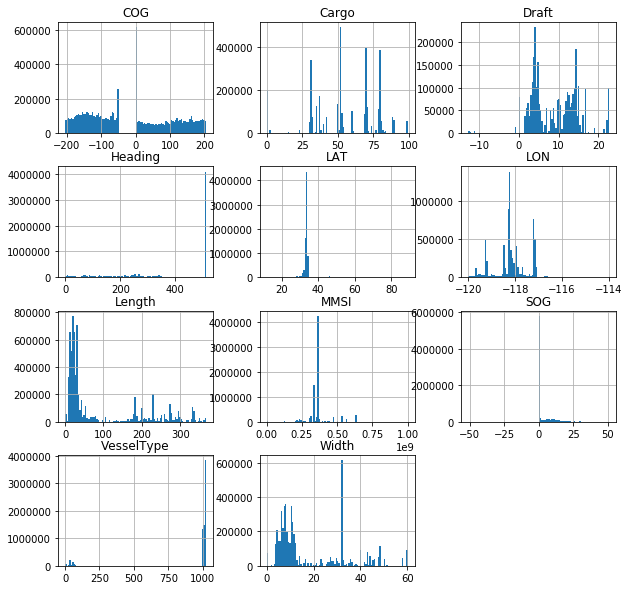

In [4]:
plt.rcParams['figure.figsize'] = 10,10
df.hist(bins=100);
plt.show()

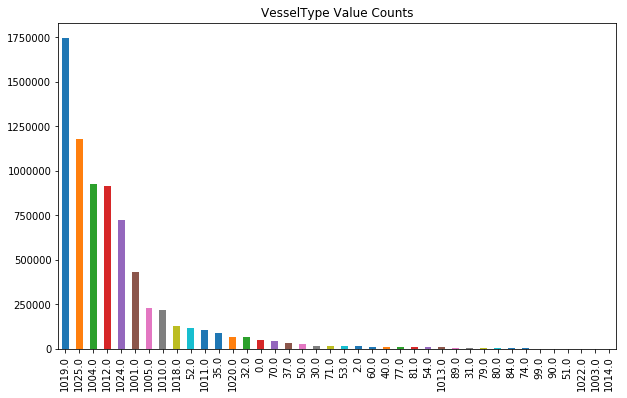

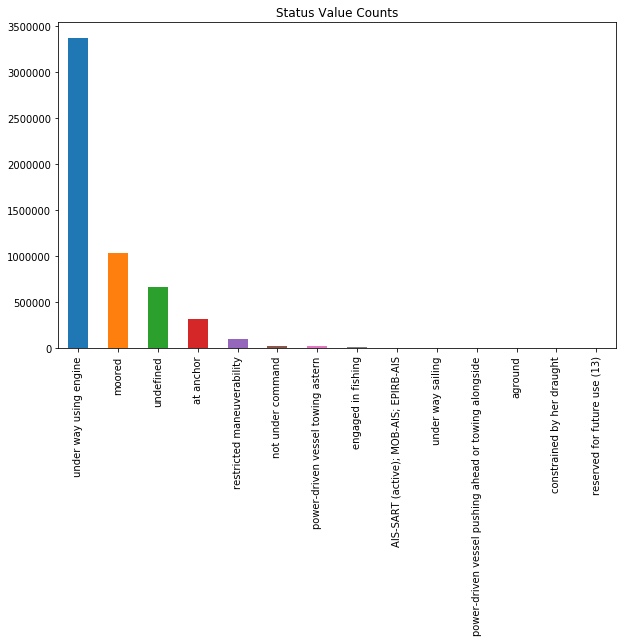

In [5]:
plt.rcParams['figure.figsize'] = 10,6
for col in ['VesselType','Status']:
    df[col].value_counts().plot(kind='bar')
    plt.title(str(col)+ " Value Counts")
    plt.show()

### What are the vessel types and other features? SOG? COG versus Heading? Draft? Would strongly suggest including some sort of data dictionary or guide to what these columns mean

### Need to subset. My code to find datapoints within a certain time and distance is still running. Erin focused on time, I thought I would focus on region 

In [6]:
print("Min LAT value: {}, Max LAT value:{}".format(np.min(df.LAT.values),np.max(df.LAT.values)))
print("Min LON value: {}, Max LON value:{}".format(np.min(df.LON.values),np.max(df.LON.values)))

Min LAT value: 11.715530000000001, Max LAT value:88.89163
Min LON value: -120.0, Max LON value:-114.00007


In [7]:
#Data cleaning
df['MMSI'] = df['MMSI'].astype(str)
df.BaseDateTime = pd.to_datetime(df.BaseDateTime, errors='raise')
df['LAT'] = df['LAT'].astype(str)
df['LON'] = df['LON'].astype(str)
df['LAT_int'], df['LAT_dec'] = df['LAT'].str.split('.', 1).str
df['LON_int'], df['LON_dec'] = df['LON'].str.split('.', 1).str
df['LATLON_ints'] = list(zip(df.LAT_int, df.LON_int))

high_traffic_region = df['LATLON_ints'].value_counts().index[0]

#find the highest populated lat/lon pair
region_df = df[df.LATLON_ints == high_traffic_region]
print('Highest traffic region: {} Number of rows: {}'.format(high_traffic_region, region_df.shape[0]))

#Dropping nulls
region_df = region_df.dropna(how='any')

region_df['LAT'] = region_df['LAT'].astype(float)
region_df['LON'] = region_df['LON'].astype(float)
df_min = region_df[['MMSI', 'BaseDateTime', 'LAT','LON', 'VesselType', 'SOG','COG','Status','Cargo']].copy()
print('Number of rows after dropping nulls', df_min.shape[0])

Highest traffic region: ('33', '-118') Number of rows: 3684367
Number of rows after dropping nulls 1128126


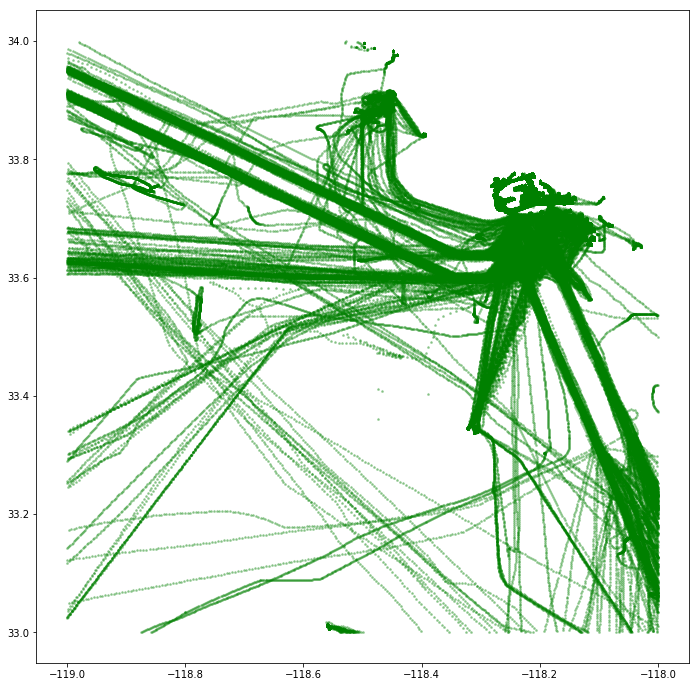

In [8]:
geometry = [Point(xy) for xy in zip(df_min['LON'], df_min['LAT'])]
gdf = GeoDataFrame(df_min, geometry=geometry)
gdf['date'] = gdf.BaseDateTime.apply(lambda x: x.date())
gdf.plot(marker='*', color='green', markersize=5, figsize=(12, 12), alpha =0.3);

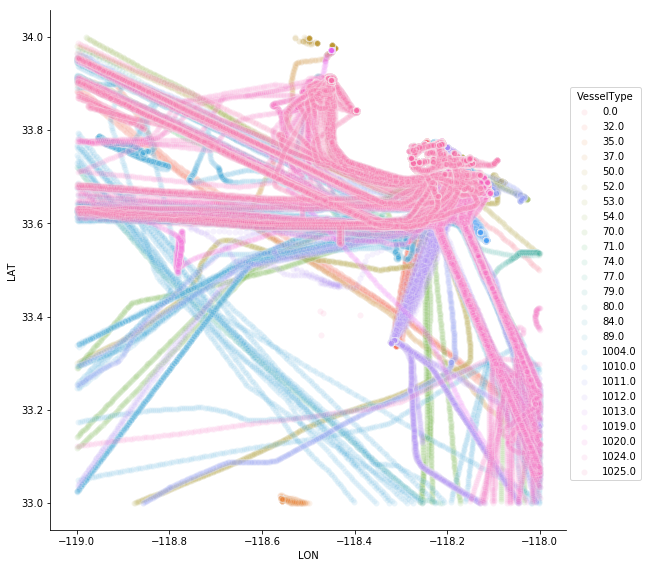

In [9]:
sns.pairplot(x_vars=["LON"], y_vars=["LAT"], data=gdf,  hue="VesselType", size=8, plot_kws={'alpha':0.1})
plt.show()

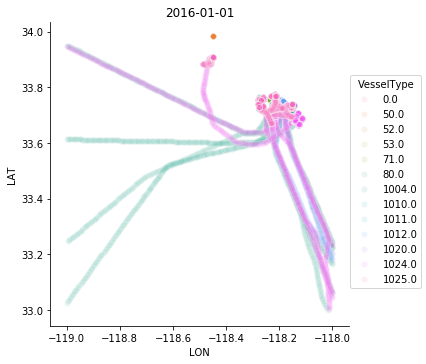

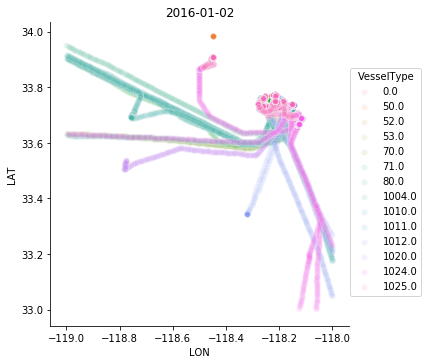

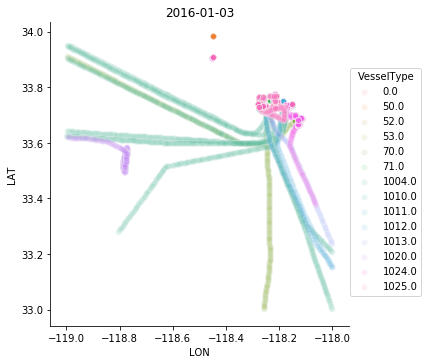

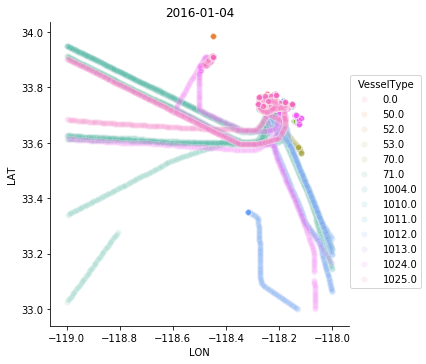

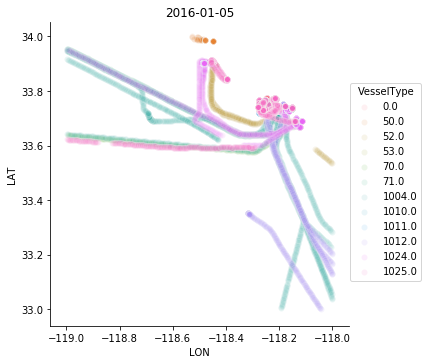

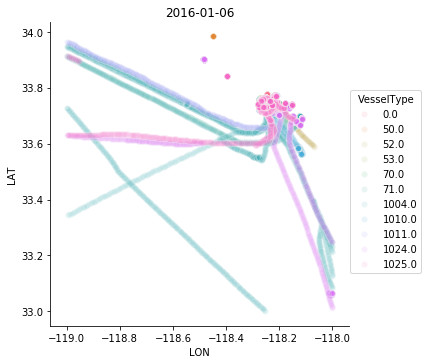

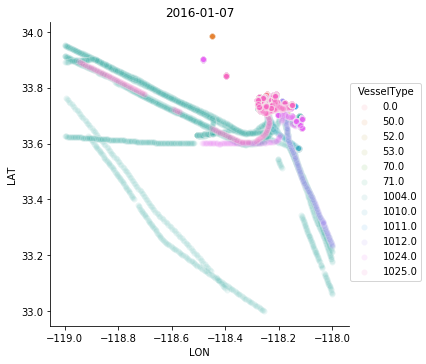

In [10]:
for i in gdf.date.unique()[:7]: #looking at 7 days
    day_df = gdf[gdf.date==i]
    sns.pairplot(x_vars=["LON"], y_vars=["LAT"], data=day_df,  hue="VesselType", size=5, plot_kws={'alpha':0.1})
    plt.title(str(day_df.date.values[0]))
    plt.show()

### Visualizations above show clear paths to and from this port. 
### Did an analysis to find boats close in time and space (within 5 minutes and 500 yards). For proof of concept, I only focused on one day (January 26, 2016). Visualized below

Text(0.5,1,'Close boats Jan 26 2016')

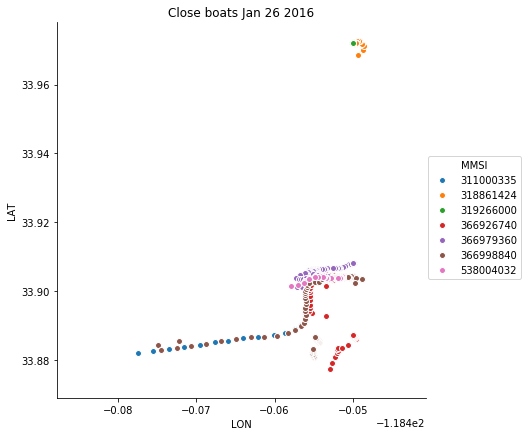

In [11]:
close_boats = pd.read_csv('Close_boats_jan_26.csv') 
sns.pairplot(x_vars=["LON"], y_vars=["LAT"], data=close_boats,  hue="MMSI", size=6)
plt.title('Close boats Jan 26 2016')

Text(0.5,1,'Movement of two close proximity boats')

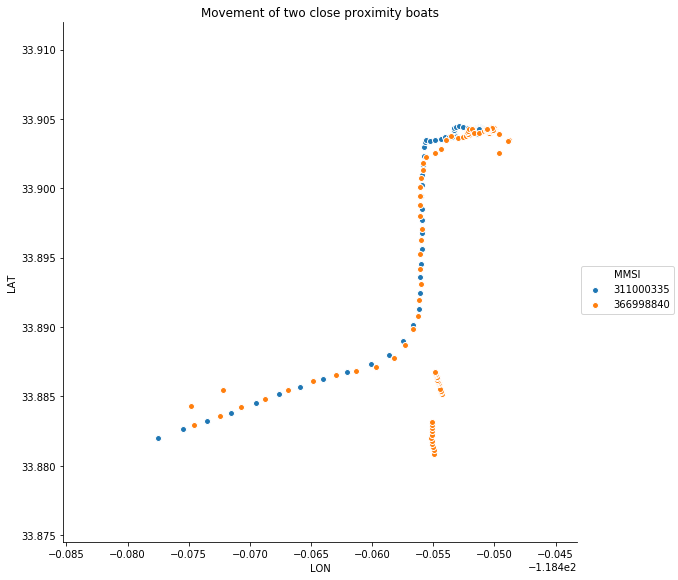

In [12]:
sns.pairplot(x_vars=["LON"], y_vars=["LAT"], data=close_boats[(close_boats['MMSI']==311000335)|(close_boats['MMSI']==366998840)],  hue="MMSI", size=8)
plt.title('Movement of two close proximity boats')

### What are the rules of the sea? Would the above interaction be considered safe or unsafe? Would suggest including some directions or examples of interactions deemed safe or unsafe.

### Can we use this data to, for example, classify Vessel Types?

In [13]:
import datetime
ml_df = df.dropna(how='any')
ml_df.BaseDateTime = pd.to_datetime(ml_df.BaseDateTime, errors='raise')
ml_df['date'] = ml_df.BaseDateTime.apply(lambda x: x.date())
ml_df = ml_df[ml_df.date<datetime.date(2016, 1, 3)]

ml_df['LAT'] = ml_df['LAT'].astype(float)
ml_df['LON'] = ml_df['LON'].astype(float)
# ml_df.reset_index()
ml_df.shape

(124632, 22)

In [14]:
index_cols = ['MMSI', 'BaseDateTime']
feature_cols = ['LAT','LON','SOG','COG', 'Heading']
target_col = ['VesselType']

In [15]:
X = ml_df[feature_cols]
y= ml_df[target_col]

In [16]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = ensemble.GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [17]:
preds = clf.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score( y_test, preds)

0.93978416977574519

### Using just geographical features, we can correctly predict VesselType 93.98% of the time

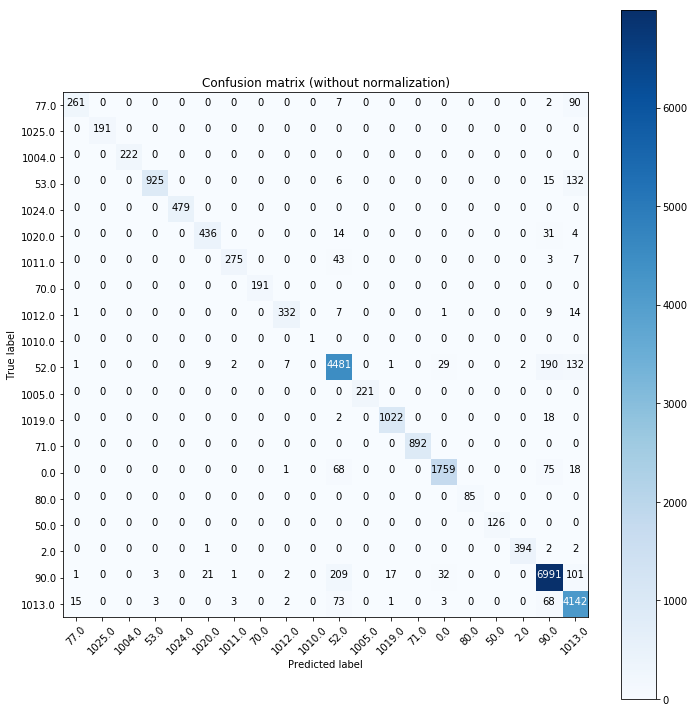

In [19]:
from sklearn.metrics import confusion_matrix
import itertools
plt.rcParams['figure.figsize'] = 10,10

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=ml_df.VesselType.unique(),
                      title='Confusion matrix (without normalization)')

plt.show()

# Could use these misclassifiations to identify potential anomalies

## Other potentially interesting avenues: relating vessel type to Cargo size, comparing the Long Beach port to the Marina Del Rey(?) port

Text(0.5,1,'Distribution of Cargo sizes by Vessel Types 0-100')

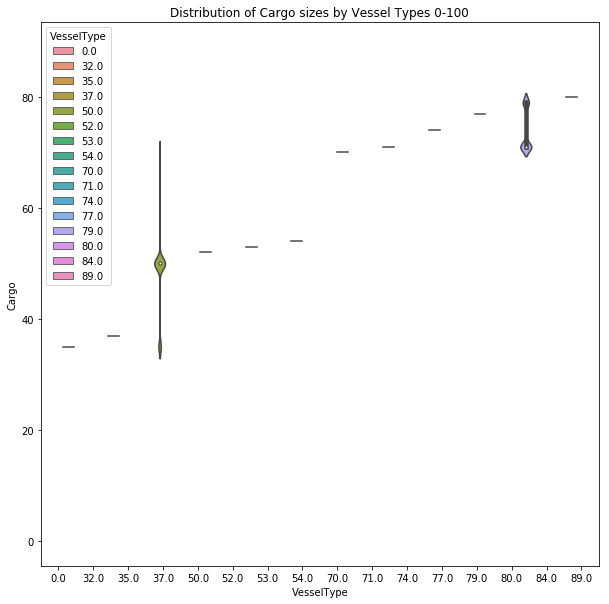

In [20]:
sns.violinplot(x='VesselType', y='Cargo', data=gdf[gdf.VesselType<100], hue="VesselType", size=10, width=5);
plt.title('Distribution of Cargo sizes by Vessel Types 0-100')

Text(0.5,1,'Distribution of Cargo sizes by Vessel Types >1000')

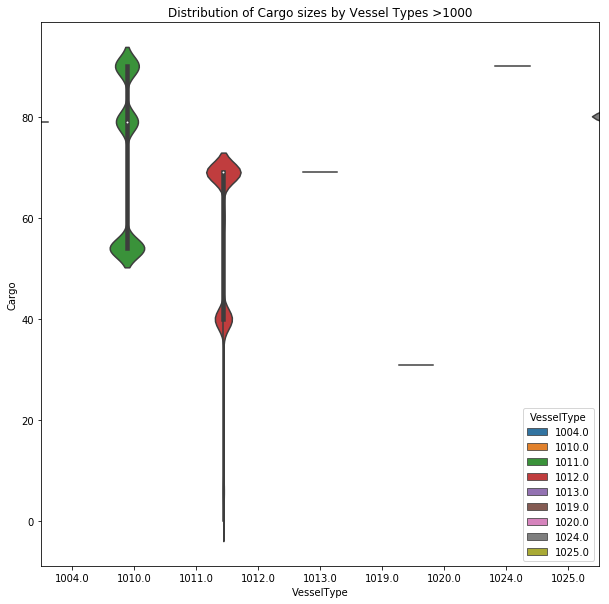

In [21]:
sns.violinplot(x='VesselType', y='Cargo', data=gdf[gdf.VesselType>100], hue="VesselType", size=10, width=5);
plt.title('Distribution of Cargo sizes by Vessel Types >1000')

Text(0.5,1,'Distribution of Cargo sizes by Vessel Types (Top 10 Most Common)')

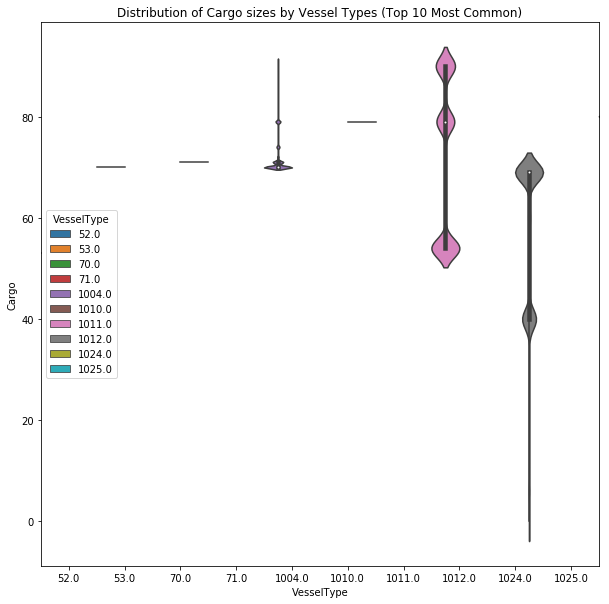

In [22]:
sns.violinplot(x='VesselType', y='Cargo', data=gdf[gdf.VesselType.isin(gdf.VesselType.value_counts().index[:10])], hue="VesselType", width=5, size=10);
plt.title('Distribution of Cargo sizes by Vessel Types (Top 10 Most Common)')

### Are there noticable differences between the Marina Del Rey and Long Beach ports?

In [29]:
#Making dataframes to compare Marina Del Ray to Long Beach Port
la_gdf = gdf[(gdf.LAT>33.8)&(gdf.LAT<34)&(gdf.LON<-118.4)&(gdf.LON>-118.6)] #LA Port
lb_gdf = gdf[(gdf.LAT>33.6)&(gdf.LAT<33.8)&(gdf.LON<-118.1)&(gdf.LON>-118.3)] #LBC Port

In [30]:
la_gdf.head()

,MMSI,BaseDateTime,LAT,LON,VesselType,SOG,COG,Status,Cargo,geometry,date
21,366979360,2016-01-01 00:00:00,33.90427,-118.45363,1025.0,7.0,35.9,under way using engine,52.0,POINT (-118.45363 33.90427),2016-01-01
30,366979360,2016-01-01 00:04:40,33.90810,-118.45044,1025.0,0.9,163.7,under way using engine,52.0,POINT (-118.45044 33.9081),2016-01-01
33,366979360,2016-01-01 00:07:00,33.90840,-118.44986,1025.0,0.1,23.9,under way using engine,52.0,POINT (-118.44986 33.9084),2016-01-01
38,366979360,2016-01-01 00:01:10,33.90633,-118.45226,1025.0,7.1,27.2,under way using engine,52.0,POINT (-118.45226 33.90633),2016-01-01
50,366979360,2016-01-01 00:02:21,33.90783,-118.45063,1025.0,2.5,46.9,under way using engine,52.0,POINT (-118.45063 33.90783),2016-01-01


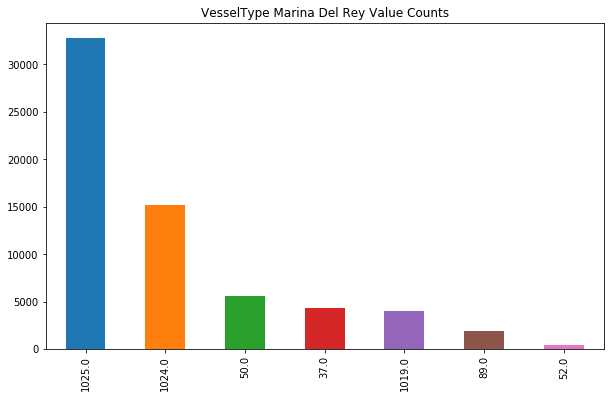

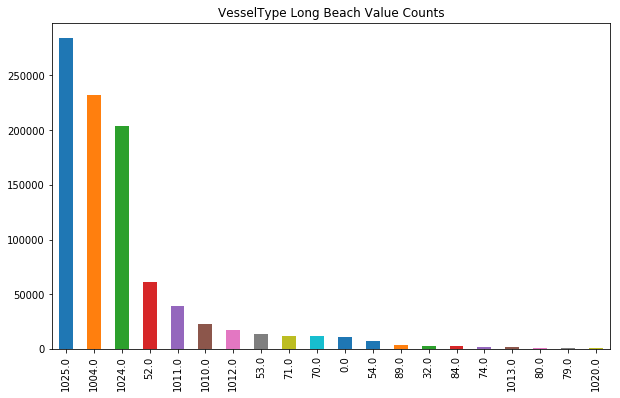

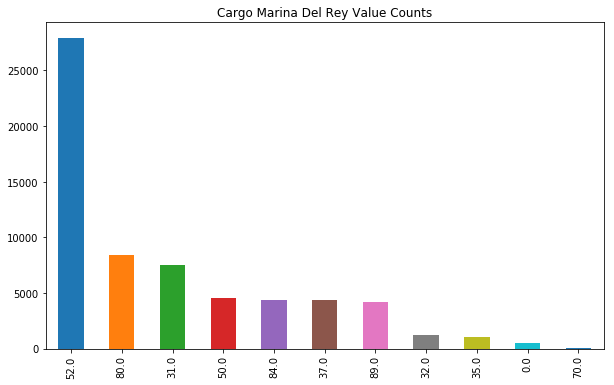

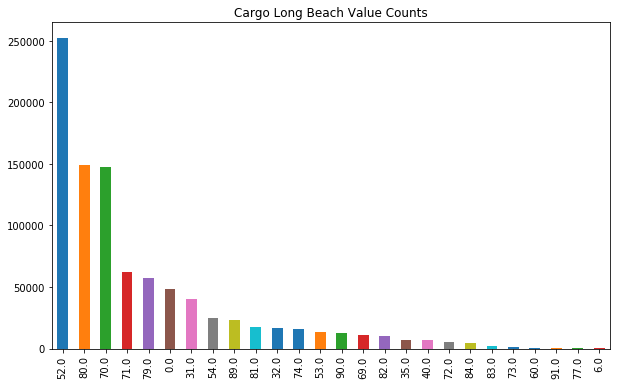

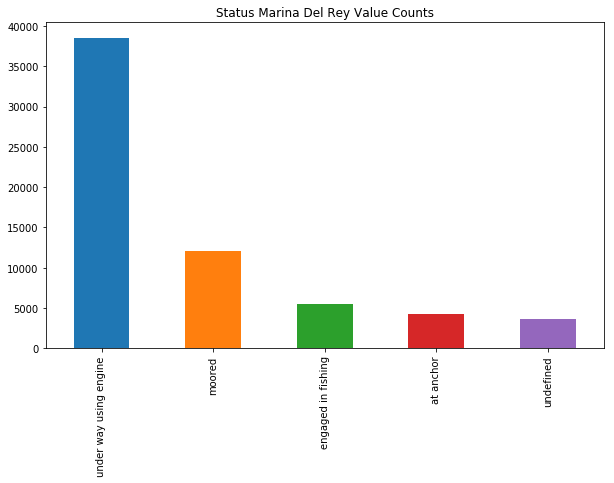

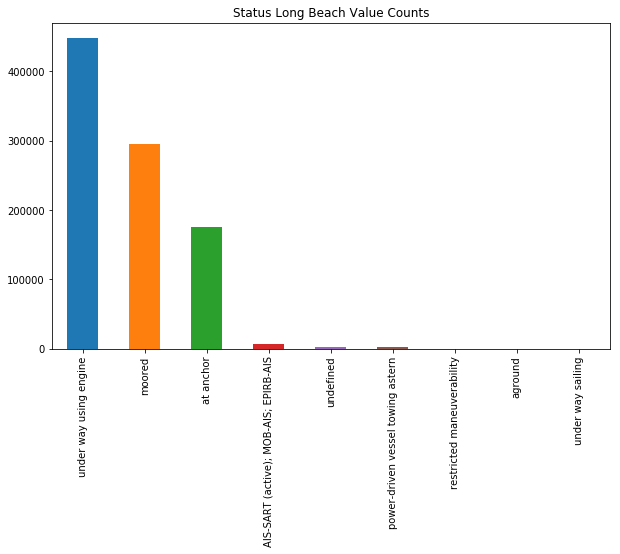

In [35]:
plt.rcParams['figure.figsize'] = 10,6

cols = ['VesselType', 'Cargo', 'Status']

for col in cols:
    la_gdf[col].value_counts().plot(kind='bar')
    plt.title(str(col)+ " Marina Del Rey Value Counts")
    plt.show()
    lbc_gdf[col].value_counts().plot(kind='bar')
    plt.title(str(col)+ " Long Beach Value Counts")
    plt.show()

## Code to find matches close in time and space. (Slow!)

In [3]:
from geopy.distance import great_circle
import numpy as np

interval = 150 #time interval (seconds)
distance = 1500 #1500feet  #500 yards 
matching_indices =[]

neighbor_vessels = pd.DataFrame(columns= df.columns)
df1 = gdf_reduced.sort_values(by='BaseDateTime', ascending=True) #this is the dataframe to look for matches within

#df1=df1[df1.date==datetime.date(2016, 1, 26)] if filtering by time

for i,v in enumerate(df1.BaseDateTime.values): 
    
    df2 = df1.iloc[i+1:,]
    df2 = df2[df2.date==df1.iloc[i].date]
    time_min = v - pd.Timedelta(seconds=interval)
    time_max = v + pd.Timedelta(seconds=interval) 
    temp_df = df2[(df2.BaseDateTime > time_min)&(df2.BaseDateTime < time_max)] #makes temp df of datapoints close in time
    
    temp_df['latlon'] = list(zip(temp_df.LAT, temp_df.LON))
    #temp_df.reset_index(inplace=True)
    
    temp_df['dist'] = temp_df['latlon'].apply(lambda x: great_circle(temp_df.latlon.values[0], x).feet) #calc distances from row 0
    
    closers = temp_df[(np.abs(temp_df.dist) < distance)] #filter points close in time
    closers = closers.drop_duplicates(subset ='MMSI') #drop duplicates
    
    if len(closers) > 1:
        neighbor_vessels = neighbor_vessels.append(closers) #using dataframes
        #matching_indices.append(closers.index.values) #using array
    print(len(df2))

ModuleNotFoundError: No module named 'geopy'